In [128]:
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn.metrics import mean_squared_error 
from sklearn.preprocessing import StandardScaler as zscore # zscore
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso #LRlasso
from joblib import dump, load #to save models in files
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
import math as m
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import re
import json

In [129]:
from sklearn.model_selection import GridSearchCV
def gridcv(X, y, model, param_grid, naimpute=False, prepy=True, scorer = 'neg_mean_squared_error', cv_meth = LeaveOneOut()):
    """
    Perform Cross-Validation (defaukt: LOOCV) with hyperparameter tuning using GridSearchCV.
    
    Parameters:
    ----------
    X : pandas DataFrame or numpy array
        The feature matrix.
        
    y : pandas Series or numpy array
        The target variable.
        
    model : scikit-learn estimator
        The machine learning model to be used, should be an uninitialized model instance 
        (e.g., Lasso(), not Lasso(alpha=1.0)).
        
    param_grid : dict
        Dictionary containing the hyperparameters to be tuned and their possible values. 
        The keys should be prefixed with 'regressor__' to work with the pipeline.
        
    naimpute : bool, optional (default=False)
        Toggle imputation for missing values. 
        Currently not implemented; will print a message and return 0 if set to True.
        
    prepy : bool, optional (default=True)
        Toggle preprocessing target variable 'y' by setting any negative values to zero.
        
    scorer : str, callable, or None, optional (default='neg_mean_squared_error')
        A string or a scorer callable object / function with signature scorer(estimator, X, y). 
        For valid scoring strings, see the scikit-learn documentation.
        
    cv_meth : cross-validation generator, optional (default=LeaveOneOut())
        A cross-validation splitting strategy. 
        Possible inputs for cv are integers to specify the number of folds in a (Stratified)KFold, 
        CV splitter, cross-validation generator iterators, or an iterable.
        
    Returns:
    -------
    overall_metric : dict
        Dictionary containing the overall metrics and other details from the GridSearchCV.
        
    out_model : GridSearchCV object
        Fitted GridSearchCV object.
        
    best_params : dict
        Dictionary containing the best hyperparameters found by GridSearchCV.

    Call:
    ------
    from sklearn.model_selection import KFold

    # set up KFold cross-validator
    kfold_cv = KFold(n_splits=3, shuffle=True, random_state=42)

    param_grid = {
        'regressor__alpha': np.array(np.arange(0.0125, 0.0425, 0.0025)),
        'regressor__fit_intercept': [True, False]
    }
    print(param_grid)

    # Call the gridcv function with KFold as the cross-validation method
    lasso_fullkfold_scores, lasso_fullkfold_model, best_param = gridcv(
        X, 
        y,
        Lasso(max_iter=4000),
        param_grid,
        scorer='r2', 
        cv_meth=kfold_cv
    )
    dump(lasso_fullkfold_model, './models/lasso_fullkfold_model.pkl') # save the model as .pkl
    """

    # overall_metric = {'CV': cv_meth, 'scoring_metric': scorer} originally
    overall_metric = {'CV': str(cv_meth), 'scoring_metric': str(scorer)} # transformed to string because json dump scores later

    if prepy:
        y[y < 0] = 0
    
    if naimpute:
      print("not implemented")
      return 0


    pipeline = Pipeline([
        ('scaler', zscore()), 
        ('regressor', model)        # Regression model
    ])

    
    # declaring an Grid object
    # score : https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    out_model = GridSearchCV(pipeline, param_grid=param_grid, cv=cv_meth, scoring=scorer).fit(X,y)
    # GridSearchCV need the regressor__ prefix for the pipiline object in the para_grid later when called

    best_pipeline = out_model.best_estimator_
    y_pred = best_pipeline.predict(X)

    overall_metric['correlation_true_pred'] = list(np.corrcoef(list(y), list(y_pred)))
    overall_metric['correlation_true_pred'][0] = list(overall_metric['correlation_true_pred'][0])
    overall_metric['correlation_true_pred'][1] = list(overall_metric['correlation_true_pred'][1])


    # LOOCV folds: split{i}_test_score (number of data points minus one) 
    overall_metric['fold_scores'] = [out_model.cv_results_[f'split{i}_test_score'][out_model.best_index_] for i in range(out_model.n_splits_)]
    best_params = out_model.best_params_


    # access the 'regressor' step from the best pipeline and then its coefficients
    coefficients = best_pipeline.named_steps['regressor'].coef_
    overall_metric['non_zero_coefficients'] = coefficients[coefficients != 0]
    overall_metric['non_zero_coefficients'] = overall_metric['non_zero_coefficients'].tolist()
    overall_metric['non_zero_features'] = list(X.columns[np.where(coefficients != 0)[0]])

    # printing section
    print("best parameter from gridsearch>>\n", out_model.best_params_)
    print(overall_metric['CV'])
    print(overall_metric['scoring_metric'])
    print("correlation Matrix>>\n", overall_metric['correlation_true_pred'])
    print("non_zero_features>>\n",overall_metric['non_zero_features'])
    print("scores for each fold>>\n",overall_metric['fold_scores'])

    return overall_metric, out_model, best_params


# Data
> mutual sample points for transcriptome and GC-MS data


In [130]:
tr_mut = pd.read_csv("/home/t44p/PW_rawdata/tr_gc_mutual/tr_mut.csv", sep=",")
gcms_mut = pd.read_csv("/home/t44p/PW_rawdata/tr_gc_mutual/gcms_mut.csv", sep=",")
lcms_mut = pd.read_csv("/home/t44p/PW_rawdata/tr_gc_mutual/lcms_mut.csv", sep=",")


In [131]:
#X = tr_mut.transpose()
#X.columns =X.iloc[0]
#print(X.columns[0])
#print(tr_mut['ref'].iloc[-1])
#X.iloc[0,0]
#X.to_csv("/home/t44p/PW_rawdata/tr_gc_mutual/tr_mut_transposed.csv", index=False)
# X to big so deleted 2nd row after transpose (those are the columns name that wher row names before)
X = pd.read_csv("/home/t44p/PW_rawdata/tr_gc_mutual/tr_mut_transposed.csv", sep=",")

## Preparing targets

In [132]:
y_sucrose = gcms_mut.iloc[59,1:]
print(gcms_mut.iloc[59,0])

y_citricAcid = gcms_mut.iloc[13,1:]
print(gcms_mut.iloc[13,0])

y_glucose = gcms_mut.iloc[23,1:]
print(gcms_mut.iloc[23,0])

y_isoleucine = gcms_mut.iloc[38,1:]
print(gcms_mut.iloc[38,0])

y_leucine = gcms_mut.iloc[39,1:]
print(gcms_mut.iloc[39,0])

y_valine =  gcms_mut.iloc[66,1:]
print(gcms_mut.iloc[66,0])

# LCMS
y_trehalose = lcms_mut.iloc[2,1:]
print(lcms_mut.iloc[2,0])

y_rutin = lcms_mut.iloc[44,1:]
print(lcms_mut.iloc[44,0])

y_oxGlut = lcms_mut.iloc[7,1:]
print(lcms_mut.iloc[7,0])




sucrose_437_361_rt13.77
citric_acid_273_375_rt9.72
glucose_160_rt9.81
isoleucin_158_233_rt.5.21
leucine_158_232_rt4.97
valine_144_218_rt4.42
Trehalose
 Rutin
Oxidized glutathione*


# Data exploration

## Distribution of target variable

sucrose


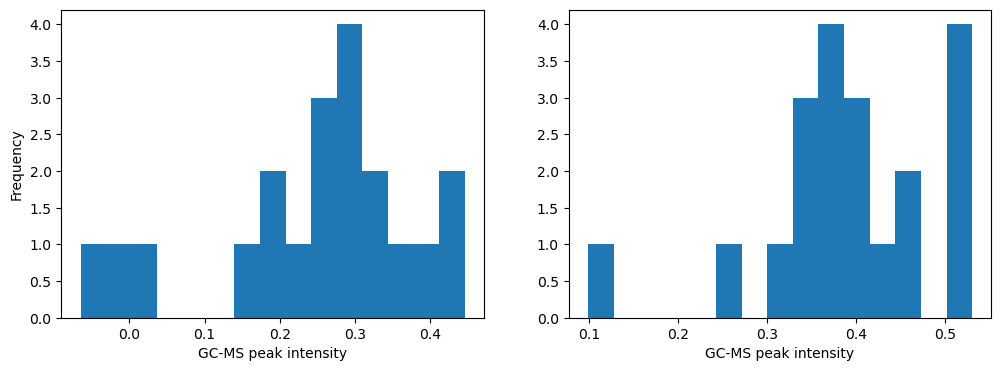

citric acid


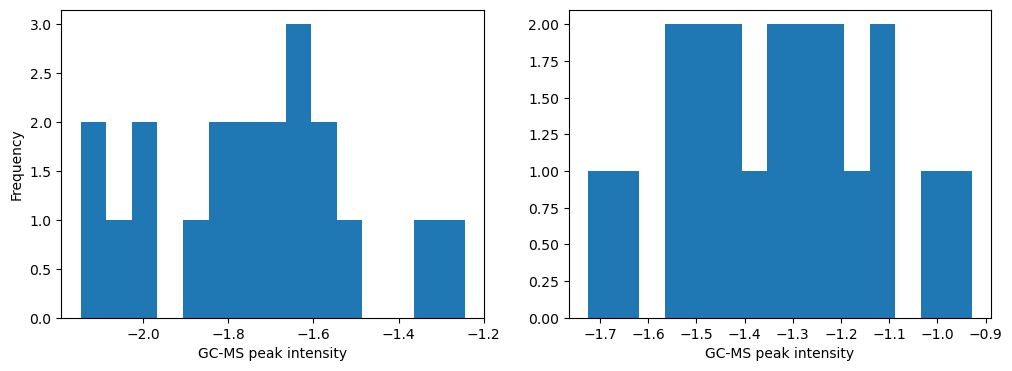

glucose


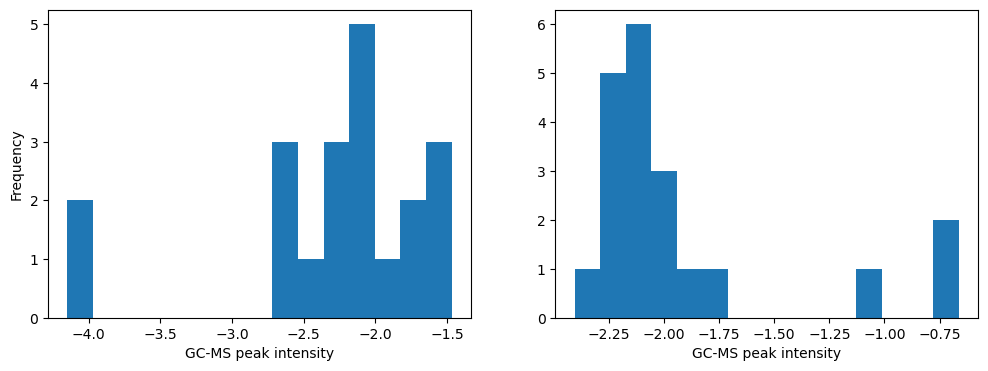

isoleucine


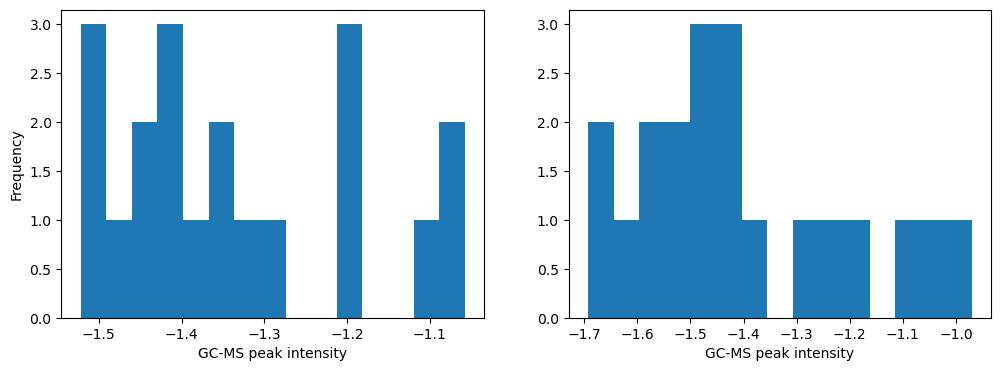

leucine


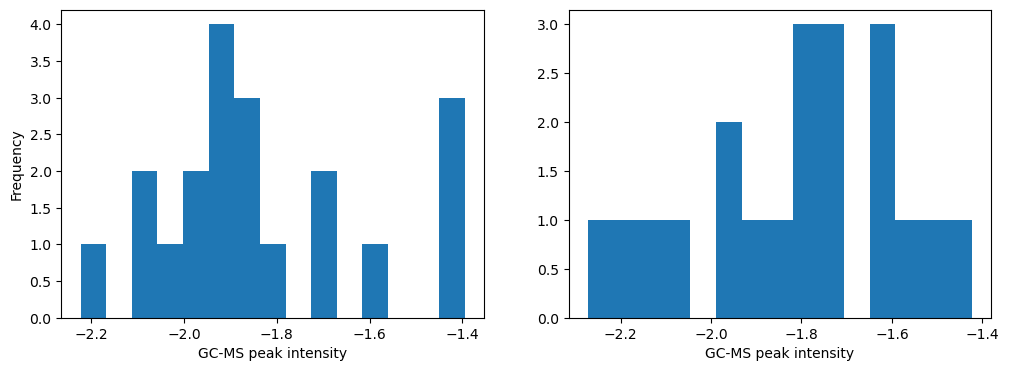

valine


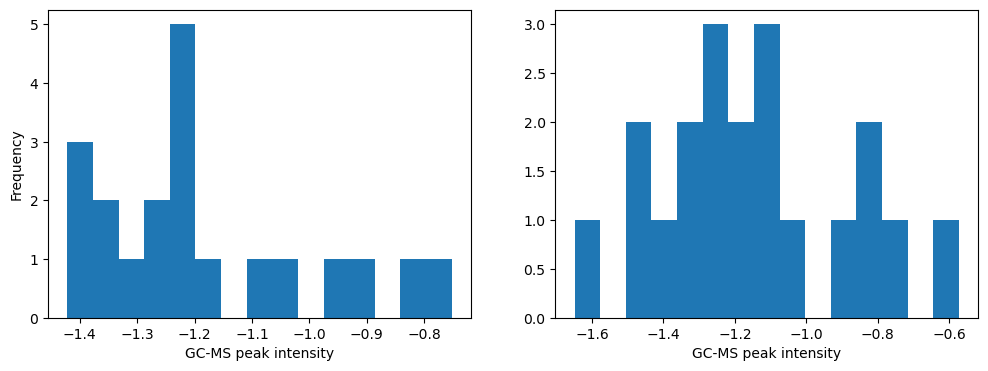

rutin


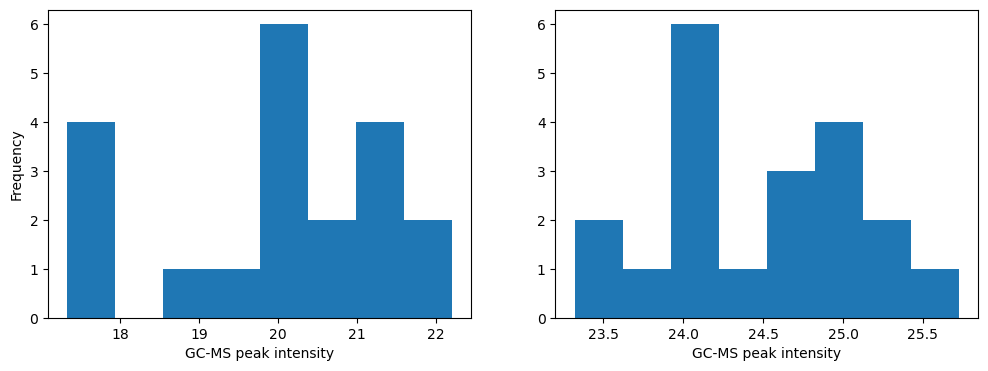

oxidized glutathione


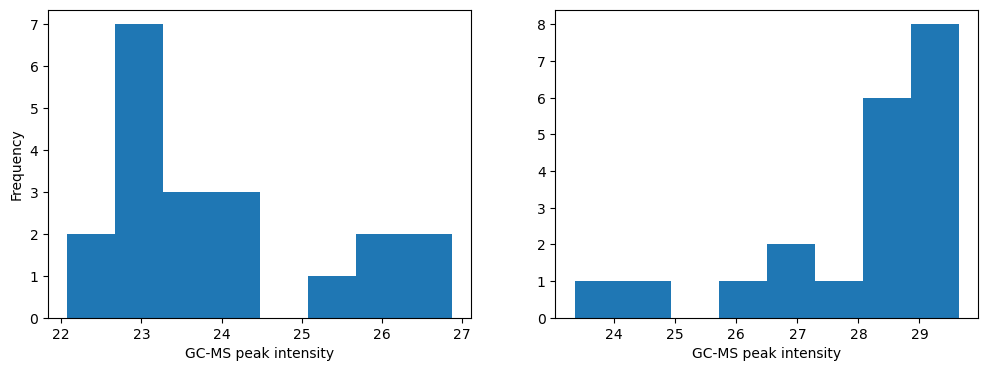

trehalose


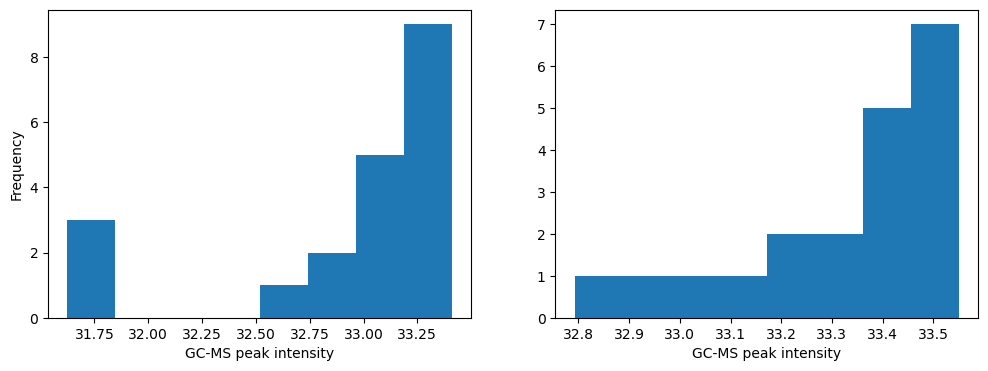

In [133]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns
axes[0].hist(y_sucrose[0:20], bins=15) # bins sqrt(samples), small sample, bins=n
axes[1].hist(y_sucrose[20:], bins=15) # bins sqrt(samples), small sample, bins=n
axes[0].set_xlabel('GC-MS peak intensity')
axes[0].set_ylabel('Frequency')
axes[1].set_xlabel('GC-MS peak intensity')
print("sucrose")
plt.show()
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns
axes[0].hist(y_citricAcid[0:20], bins=15) # bins sqrt(samples), small sample, bins=n
axes[1].hist(y_citricAcid[20:], bins=15) # bins sqrt(samples), small sample, bins=n
axes[0].set_xlabel('GC-MS peak intensity')
axes[0].set_ylabel('Frequency')
axes[1].set_xlabel('GC-MS peak intensity')
print("citric acid")
plt.show()
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns
axes[0].hist(y_glucose[0:20], bins=15) # bins sqrt(samples), small sample, bins=n
axes[1].hist(y_glucose[20:], bins=15) # bins sqrt(samples), small sample, bins=n
axes[0].set_xlabel('GC-MS peak intensity')
axes[0].set_ylabel('Frequency')
axes[1].set_xlabel('GC-MS peak intensity')
print("glucose")
plt.show()
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns
axes[0].hist(y_isoleucine[0:20], bins=15) # bins sqrt(samples), small sample, bins=n
axes[1].hist(y_isoleucine[20:], bins=15) # bins sqrt(samples), small sample, bins=n
axes[0].set_xlabel('GC-MS peak intensity')
axes[0].set_ylabel('Frequency')
axes[1].set_xlabel('GC-MS peak intensity')
print("isoleucine")
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns
axes[0].hist(y_leucine[0:20], bins=15) # bins sqrt(samples), small sample, bins=n
axes[1].hist(y_leucine[20:], bins=15) # bins sqrt(samples), small sample, bins=n
axes[0].set_xlabel('GC-MS peak intensity')
axes[0].set_ylabel('Frequency')
axes[1].set_xlabel('GC-MS peak intensity')
print("leucine")
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns
axes[0].hist(y_valine[0:20], bins=15) # bins sqrt(samples), small sample, bins=n
axes[1].hist(y_valine[20:], bins=15) # bins sqrt(samples), small sample, bins=n
axes[0].set_xlabel('GC-MS peak intensity')
axes[0].set_ylabel('Frequency')
axes[1].set_xlabel('GC-MS peak intensity')
print("valine")
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns
axes[0].hist(y_rutin[0:20], bins=8) # bins sqrt(samples), small sample, bins=n
axes[1].hist(y_rutin[20:], bins=8) # bins sqrt(samples), small sample, bins=n
axes[0].set_xlabel('GC-MS peak intensity')
axes[0].set_ylabel('Frequency')
axes[1].set_xlabel('GC-MS peak intensity')
print("rutin")
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns
axes[0].hist(y_oxGlut[0:20], bins=8) # bins sqrt(samples), small sample, bins=n
axes[1].hist(y_oxGlut[20:], bins=8) # bins sqrt(samples), small sample, bins=n
axes[0].set_xlabel('GC-MS peak intensity')
axes[0].set_ylabel('Frequency')
axes[1].set_xlabel('GC-MS peak intensity')
print("oxidized glutathione")
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns
axes[0].hist(y_trehalose[0:20], bins=8) # bins sqrt(samples), small sample, bins=n
axes[1].hist(y_trehalose[20:], bins=8) # bins sqrt(samples), small sample, bins=n
axes[0].set_xlabel('GC-MS peak intensity')
axes[0].set_ylabel('Frequency')
axes[1].set_xlabel('GC-MS peak intensity')
print("trehalose")
plt.show()



## GC-MS intensities over desiccation and rehydration series

/tmp/ipykernel_4928/2429013202.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(gcms_mut.columns[1:21], rotation=90)
/tmp/ipykernel_4928/2429013202.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(gcms_mut.columns[1:21], rotation=90)
/tmp/ipykernel_4928/2429013202.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2].set_xticklabels(gcms_mut.columns[1:21], rotation=90)


dessication series


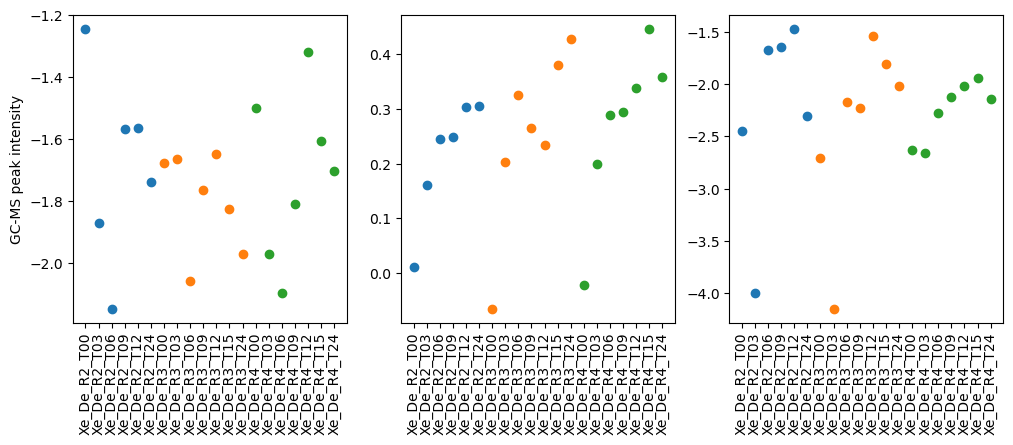

/tmp/ipykernel_4928/2429013202.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(gcms_mut.columns[21:], rotation=90)
/tmp/ipykernel_4928/2429013202.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(gcms_mut.columns[21:], rotation=90)
/tmp/ipykernel_4928/2429013202.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2].set_xticklabels(gcms_mut.columns[21:], rotation=90)


rehydration series


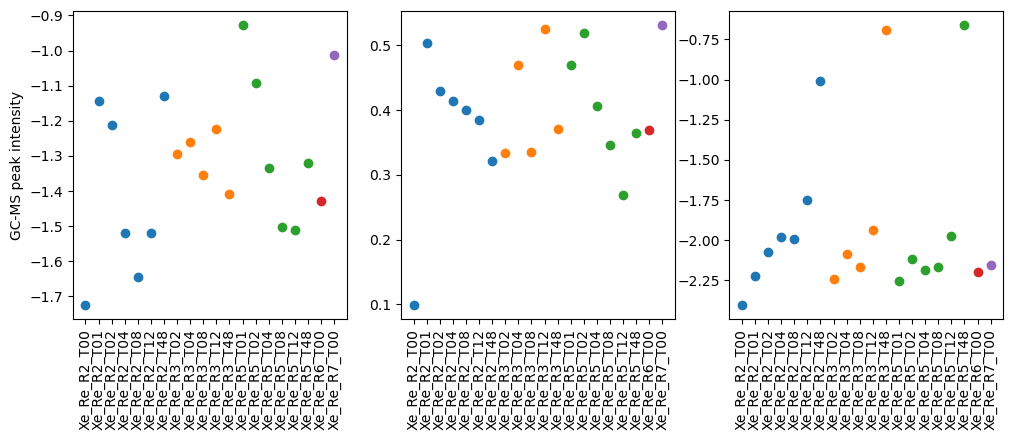

In [134]:
# citric acid

fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # 1 row, 3 columns
axes[0].scatter(gcms_mut.columns[1:7], y_citricAcid[0:6]) # R2
axes[0].scatter(gcms_mut.columns[7:14], y_citricAcid[6:13]) # R3
axes[0].scatter(gcms_mut.columns[14:21], y_citricAcid[13:20]) # R4
axes[0].set_xticklabels(gcms_mut.columns[1:21], rotation=90)
axes[0].set_ylabel('GC-MS peak intensity')

axes[1].scatter(gcms_mut.columns[1:7], y_sucrose[0:6]) # R2
axes[1].scatter(gcms_mut.columns[7:14], y_sucrose[6:13]) # R3
axes[1].scatter(gcms_mut.columns[14:21], y_sucrose[13:20]) # R4
axes[1].set_xticklabels(gcms_mut.columns[1:21], rotation=90)

axes[2].scatter(gcms_mut.columns[1:7], y_glucose[0:6]) # R2
axes[2].scatter(gcms_mut.columns[7:14], y_glucose[6:13]) # R3
axes[2].scatter(gcms_mut.columns[14:21], y_glucose[13:20]) # R4
axes[2].set_xticklabels(gcms_mut.columns[1:21], rotation=90)
print("dessication series")
plt.show()


fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # 1 row, 3 columns
axes[0].scatter(gcms_mut.columns[21:28], y_citricAcid[20:27]) # R2
axes[0].scatter(gcms_mut.columns[28:33], y_citricAcid[27:32]) # R3
axes[0].scatter(gcms_mut.columns[33:39], y_citricAcid[32:38]) # R5 
axes[0].scatter(gcms_mut.columns[39], y_citricAcid[38]) # R6
axes[0].scatter(gcms_mut.columns[40], y_citricAcid[39]) # R7
axes[0].set_xticklabels(gcms_mut.columns[21:], rotation=90)

axes[1].scatter(gcms_mut.columns[21:28], y_sucrose[20:27]) # R2
axes[1].scatter(gcms_mut.columns[28:33], y_sucrose[27:32]) # R3
axes[1].scatter(gcms_mut.columns[33:39], y_sucrose[32:38]) # R5 
axes[1].scatter(gcms_mut.columns[39], y_sucrose[38]) # R6
axes[1].scatter(gcms_mut.columns[40], y_sucrose[39]) # R7
axes[1].set_xticklabels(gcms_mut.columns[21:], rotation=90)


axes[2].scatter(gcms_mut.columns[21:28], y_glucose[20:27]) # R2
axes[2].scatter(gcms_mut.columns[28:33], y_glucose[27:32]) # R3
axes[2].scatter(gcms_mut.columns[33:39], y_glucose[32:38]) # R5 
axes[2].scatter(gcms_mut.columns[39], y_glucose[38]) # R6
axes[2].scatter(gcms_mut.columns[40], y_glucose[39]) # R7
axes[2].set_xticklabels(gcms_mut.columns[21:], rotation=90)

axes[0].set_ylabel('GC-MS peak intensity')

print("rehydration series")
plt.show()

/tmp/ipykernel_4928/464242120.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(gcms_mut.columns[1:21], rotation=90)
/tmp/ipykernel_4928/464242120.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(gcms_mut.columns[1:21], rotation=90)
/tmp/ipykernel_4928/464242120.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2].set_xticklabels(gcms_mut.columns[1:21], rotation=90)


dessication series


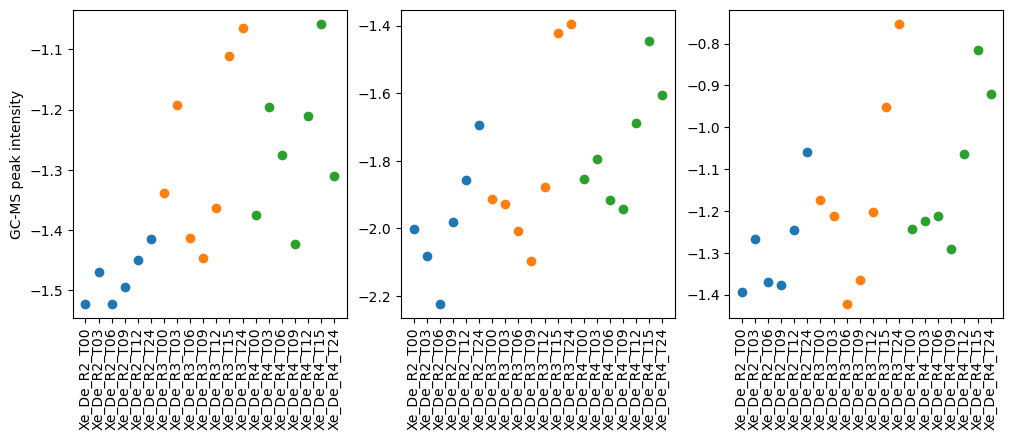

/tmp/ipykernel_4928/464242120.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(gcms_mut.columns[21:], rotation=90)
/tmp/ipykernel_4928/464242120.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(gcms_mut.columns[21:], rotation=90)
/tmp/ipykernel_4928/464242120.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2].set_xticklabels(gcms_mut.columns[21:], rotation=90)


rehydration series


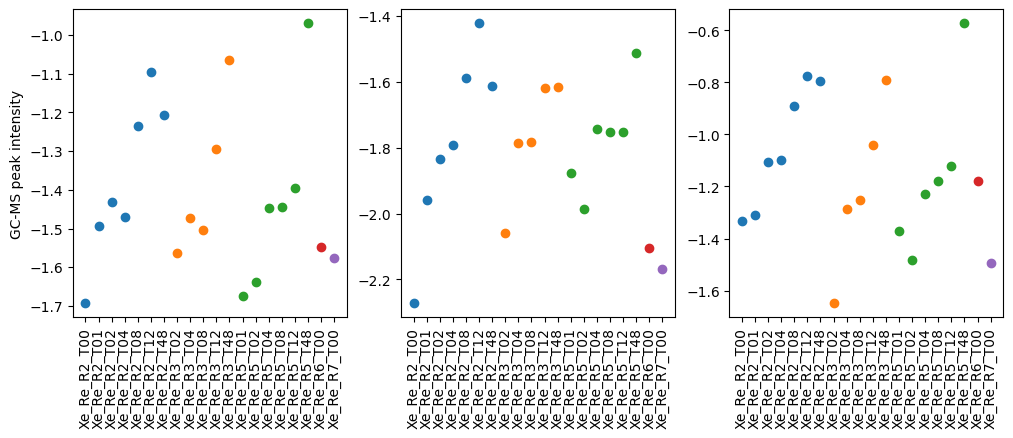

In [135]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # 1 row, 3 columns
axes[0].scatter(gcms_mut.columns[1:7], y_isoleucine[0:6]) # R2
axes[0].scatter(gcms_mut.columns[7:14], y_isoleucine[6:13]) # R3
axes[0].scatter(gcms_mut.columns[14:21], y_isoleucine[13:20]) # R4
axes[0].set_xticklabels(gcms_mut.columns[1:21], rotation=90)
axes[0].set_ylabel('GC-MS peak intensity')

axes[1].scatter(gcms_mut.columns[1:7], y_leucine[0:6]) # R2
axes[1].scatter(gcms_mut.columns[7:14], y_leucine[6:13]) # R3
axes[1].scatter(gcms_mut.columns[14:21], y_leucine[13:20]) # R4
axes[1].set_xticklabels(gcms_mut.columns[1:21], rotation=90)

axes[2].scatter(gcms_mut.columns[1:7], y_valine[0:6]) # R2
axes[2].scatter(gcms_mut.columns[7:14], y_valine[6:13]) # R3
axes[2].scatter(gcms_mut.columns[14:21], y_valine[13:20]) # R4
axes[2].set_xticklabels(gcms_mut.columns[1:21], rotation=90)
print("dessication series")
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # 1 row, 3 columns
axes[0].scatter(gcms_mut.columns[21:28], y_isoleucine[20:27]) # R2
axes[0].scatter(gcms_mut.columns[28:33], y_isoleucine[27:32]) # R3
axes[0].scatter(gcms_mut.columns[33:39], y_isoleucine[32:38]) # R5 
axes[0].scatter(gcms_mut.columns[39], y_isoleucine[38]) # R6
axes[0].scatter(gcms_mut.columns[40], y_isoleucine[39]) # R7
axes[0].set_xticklabels(gcms_mut.columns[21:], rotation=90)

axes[1].scatter(gcms_mut.columns[21:28], y_leucine[20:27]) # R2
axes[1].scatter(gcms_mut.columns[28:33], y_leucine[27:32]) # R3
axes[1].scatter(gcms_mut.columns[33:39], y_leucine[32:38]) # R5 
axes[1].scatter(gcms_mut.columns[39], y_leucine[38]) # R6
axes[1].scatter(gcms_mut.columns[40], y_leucine[39]) # R7
axes[1].set_xticklabels(gcms_mut.columns[21:], rotation=90)


axes[2].scatter(gcms_mut.columns[21:28], y_valine[20:27]) # R2
axes[2].scatter(gcms_mut.columns[28:33], y_valine[27:32]) # R3
axes[2].scatter(gcms_mut.columns[33:39], y_valine[32:38]) # R5 
axes[2].scatter(gcms_mut.columns[39], y_valine[38]) # R6
axes[2].scatter(gcms_mut.columns[40], y_valine[39]) # R7
axes[2].set_xticklabels(gcms_mut.columns[21:], rotation=90)

axes[0].set_ylabel('GC-MS peak intensity')

print("rehydration series")
plt.show()


/tmp/ipykernel_4928/3786513589.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(lcms_mut.columns[1:21], rotation=90)
/tmp/ipykernel_4928/3786513589.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(lcms_mut.columns[1:21], rotation=90)
/tmp/ipykernel_4928/3786513589.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2].set_xticklabels(lcms_mut.columns[1:21], rotation=90)


dessication series


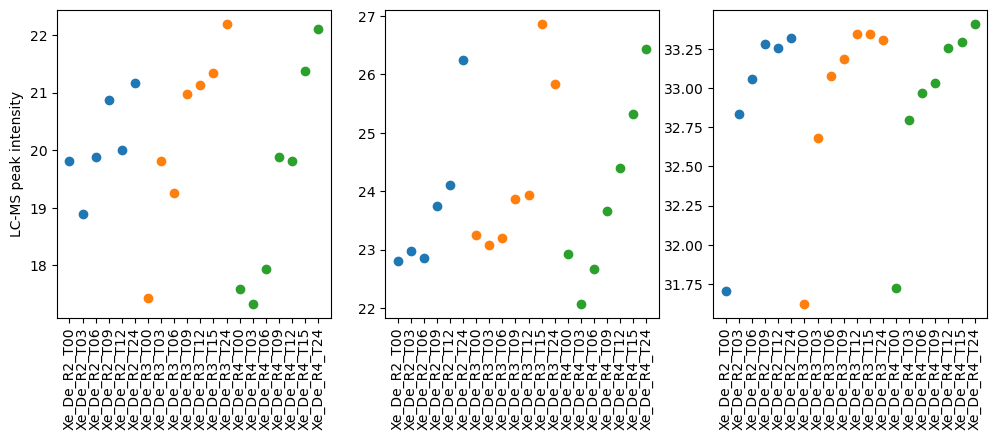

/tmp/ipykernel_4928/3786513589.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(lcms_mut.columns[21:], rotation=90)
/tmp/ipykernel_4928/3786513589.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(lcms_mut.columns[21:], rotation=90)
/tmp/ipykernel_4928/3786513589.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2].set_xticklabels(lcms_mut.columns[21:], rotation=90)


rehydration series


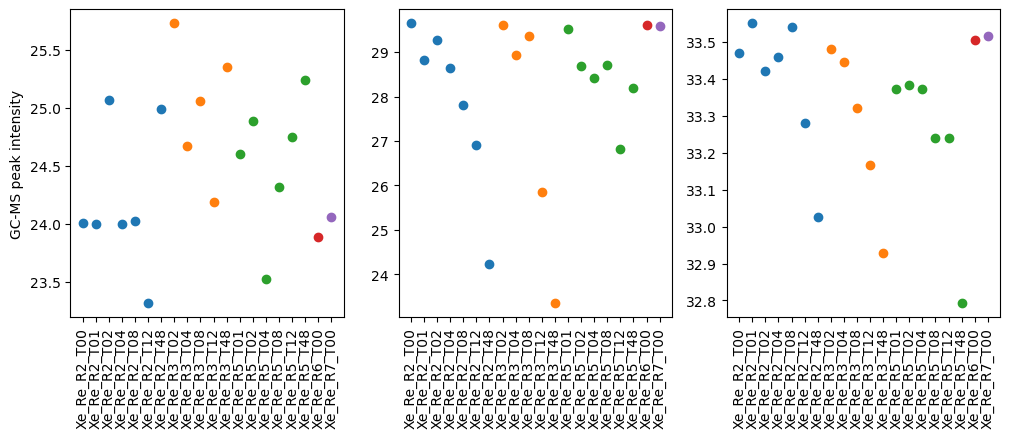

In [136]:

fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # 1 row, 3 columns
axes[0].scatter(lcms_mut.columns[1:7], y_rutin[0:6]) # R2
axes[0].scatter(lcms_mut.columns[7:14], y_rutin[6:13]) # R3
axes[0].scatter(lcms_mut.columns[14:21], y_rutin[13:20]) # R4
axes[0].set_xticklabels(lcms_mut.columns[1:21], rotation=90)
#axes[0].set_xlim(20, 40)
axes[0].set_ylabel('LC-MS peak intensity')

axes[1].scatter(lcms_mut.columns[1:7], y_oxGlut[0:6]) # R2
axes[1].scatter(lcms_mut.columns[7:14], y_oxGlut[6:13]) # R3
axes[1].scatter(lcms_mut.columns[14:21], y_oxGlut[13:20]) # R4
axes[1].set_xticklabels(lcms_mut.columns[1:21], rotation=90)

axes[2].scatter(lcms_mut.columns[1:7], y_trehalose[0:6]) # R2
axes[2].scatter(lcms_mut.columns[7:14], y_trehalose[6:13]) # R3
axes[2].scatter(lcms_mut.columns[14:21], y_trehalose[13:20]) # R4
axes[2].set_xticklabels(lcms_mut.columns[1:21], rotation=90)

print("dessication series")
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # 1 row, 3 columns
axes[0].scatter(lcms_mut.columns[21:28], y_rutin[20:27]) # R2
axes[0].scatter(lcms_mut.columns[28:33], y_rutin[27:32]) # R3
axes[0].scatter(lcms_mut.columns[33:39], y_rutin[32:38]) # R5 
axes[0].scatter(lcms_mut.columns[39], y_rutin[38]) # R6

axes[0].scatter(lcms_mut.columns[40], y_rutin[39]) # R7
axes[0].set_xticklabels(lcms_mut.columns[21:], rotation=90)

axes[1].scatter(lcms_mut.columns[21:28], y_oxGlut[20:27]) # R2
axes[1].scatter(lcms_mut.columns[28:33], y_oxGlut[27:32]) # R3
axes[1].scatter(lcms_mut.columns[33:39], y_oxGlut[32:38]) # R5 
axes[1].scatter(lcms_mut.columns[39], y_oxGlut[38]) # R6
axes[1].scatter(lcms_mut.columns[40], y_oxGlut[39]) # R7
axes[1].set_xticklabels(lcms_mut.columns[21:], rotation=90)


axes[2].scatter(lcms_mut.columns[21:28], y_trehalose[20:27]) # R2
axes[2].scatter(lcms_mut.columns[28:33], y_trehalose[27:32]) # R3
axes[2].scatter(lcms_mut.columns[33:39], y_trehalose[32:38]) # R5 
axes[2].scatter(lcms_mut.columns[39], y_trehalose[38]) # R6
axes[2].scatter(lcms_mut.columns[40], y_trehalose[39]) # R7
axes[2].set_xticklabels(lcms_mut.columns[21:], rotation=90)

axes[0].set_ylabel('GC-MS peak intensity')

print("rehydration series")
plt.show()


# Kfold Crossvalidation

In [22]:
# set up KFold cross-validator
kfold_cv = KFold(n_splits=3, shuffle=True, random_state=42)

param_grid = {
    'regressor__alpha': np.array(np.arange(0.0125, 0.0425, 0.0025)),
    'regressor__fit_intercept': [True, False]
}
print(param_grid)

# Call the gridcv function with KFold as the cross-validation method
# Lasso(max_iter=4000),

lasso_cvsucrose_scores, lasso_cvsucrose_model, best_param = gridcv(
    X, 
    y_sucrose,
    Lasso(),
    param_grid,
    prepy=False,
    scorer='r2', 
    cv_meth=kfold_cv
)
dump(lasso_cvsucrose_model, './models/lasso_cvsucrose_model.pkl') # save the model as .pkl
with open("./models/lasso_cvsucrose_scores.json", 'w') as file:
    json.dump(lasso_cvsucrose_scores, file)
    #file.write(str(lasso_cvsucrose_scores))
file.close()


{'regressor__alpha': array([0.0125, 0.015 , 0.0175, 0.02  , 0.0225, 0.025 , 0.0275, 0.03  ,
       0.0325, 0.035 , 0.0375, 0.04  ]), 'regressor__fit_intercept': [True, False]}
best parameter from gridsearch>>
 {'regressor__alpha': 0.015000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=42, shuffle=True)
r2
correlation Matrix>>
 [[1.0, 0.9803378966370346], [0.9803378966370345, 1.0]]
non_zero_features>>
 ['Xele.ptg000034l.205', 'Xele.ptg000068l.7', 'Xele.ptg000014l.41', 'Xele.ptg000020l.374', 'Xele.ptg000049l.247', 'Xele.ptg000012l.303', 'Xele.ptg000012l.442', 'Xele.ptg000012l.930', 'Xele.ptg000003l.491', 'Xele.ptg000009l.79', 'Xele.ptg000009l.94', 'Xele.ptg000009l.119', 'Xele.ptg000009l.442', 'Xele.ptg000023l.177', 'Xele.ptg000101l.69', 'Xele.ptg000038l.4', 'Xele.ptg000024l.297', 'Xele.ptg000025l.266', 'Xele.ptg000043l.106', 'Xele.ptg000043l.346', 'Xele.ptg000063l.174', 'Xele.ptg000059l.69', 'Xele.ptg000008l.151', 'Xele.ptg000008l.209']
scores for each fol

In [23]:
# set up KFold cross-validator
kfold_cv = KFold(n_splits=3, shuffle=True, random_state=42)

param_grid = {
    'regressor__alpha': np.array(np.arange(0.0125, 0.0425, 0.0025)),
    'regressor__fit_intercept': [True, False]
}
print(param_grid)

# Call the gridcv function with KFold as the cross-validation method
# Lasso(max_iter=4000),

lasso_cvglucose_scores, lasso_cvglucose_model, best_param = gridcv(
    X, 
    y_glucose,
    Lasso(),
    param_grid,
    prepy=False,
    scorer='r2', 
    cv_meth=kfold_cv
)
dump(lasso_cvglucose_model, './models/lasso_cvglucose_model.pkl') # save the model as .pkl


with open("./models/lasso_cvglucose_scores.json", 'w') as file:
    json.dump(lasso_cvglucose_scores, file)
    #file.write(str(lasso_cvsucrose_scores))
file.close()


{'regressor__alpha': array([0.0125, 0.015 , 0.0175, 0.02  , 0.0225, 0.025 , 0.0275, 0.03  ,
       0.0325, 0.035 , 0.0375, 0.04  ]), 'regressor__fit_intercept': [True, False]}
best parameter from gridsearch>>
 {'regressor__alpha': 0.0125, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=42, shuffle=True)
r2
correlation Matrix>>
 [[1.0, 0.9994904088361716], [0.9994904088361715, 1.0]]
non_zero_features>>
 ['Xele.ptg000011l.301', 'Xele.ptg000011l.430', 'Xele.ptg000010l.105', 'Xele.ptg000068l.74', 'Xele.ptg000067l.472', 'Xele.ptg000018l.1563', 'Xele.ptg000016l.332', 'Xele.ptg000001l.144', 'Xele.ptg000007l.71', 'Xele.ptg000007l.418', 'Xele.ptg000012l.772', 'Xele.ptg000044l.31', 'Xele.ptg000044l.564', 'Xele.ptg000028l.519', 'Xele.ptg000003l.525', 'Xele.ptg000013l.459', 'Xele.ptg000013l.792', 'Xele.ptg000331l.2', 'Xele.ptg000023l.344', 'Xele.ptg000021l.354', 'Xele.ptg000024l.325', 'Xele.ptg000006l.423', 'Xele.ptg000006l.592', 'Xele.ptg000006l.630', 'Xele.ptg000025l.124', 'Xele

In [24]:
# set up KFold cross-validator
kfold_cv = KFold(n_splits=3, shuffle=True, random_state=42)

param_grid = {
    'regressor__alpha': np.array(np.arange(0.0125, 0.0425, 0.0025)),
    'regressor__fit_intercept': [True, False]
}
print(param_grid)

# Call the gridcv function with KFold as the cross-validation method
# Lasso(max_iter=4000),

lasso_cvcitricAcid_scores, lasso_cvcitricAcid_model, best_param = gridcv(
    X, 
    y_citricAcid,
    Lasso(),
    param_grid,
    prepy=False,
    scorer='r2', 
    cv_meth=kfold_cv
)
dump(lasso_cvcitricAcid_model, './models/lasso_cvcitricAcid_model.pkl') # save the model as .pkl
with open("./models/lasso_cvcitricAcid_scores.json", 'w') as file:
    json.dump(lasso_cvcitricAcid_scores, file)
    #file.write(str(lasso_cvsucrose_scores))
file.close()


{'regressor__alpha': array([0.0125, 0.015 , 0.0175, 0.02  , 0.0225, 0.025 , 0.0275, 0.03  ,
       0.0325, 0.035 , 0.0375, 0.04  ]), 'regressor__fit_intercept': [True, False]}
best parameter from gridsearch>>
 {'regressor__alpha': 0.025, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=42, shuffle=True)
r2
correlation Matrix>>
 [[1.0, 0.9895817177601468], [0.9895817177601468, 1.0]]
non_zero_features>>
 ['Xele.ptg000045l.82', 'Xele.ptg000011l.21', 'Xele.ptg000011l.328', 'Xele.ptg000018l.209', 'Xele.ptg000041l.62', 'Xele.ptg000020l.342', 'Xele.ptg000020l.540', 'Xele.ptg000049l.171', 'Xele.ptg000012l.70', 'Xele.ptg000012l.134', 'Xele.ptg000028l.203', 'Xele.ptg000028l.243', 'Xele.ptg000004l.76', 'Xele.ptg000042l.33', 'Xele.ptg000042l.232', 'Xele.ptg000047l.208', 'Xele.ptg000009l.645', 'Xele.ptg000023l.139', 'Xele.ptg000023l.251', 'Xele.ptg000005l.569', 'Xele.ptg000026l.188', 'Xele.ptg000025l.209', 'Xele.ptg000025l.266', 'Xele.ptg000055l.154', 'Xele.ptg000059l.297', 'Xele.pt

## 10x Kfold Crossvalidation

In [120]:
# set up KFold cross-validator

param_grid = {
    'regressor__alpha': np.array(np.arange(0.0125, 0.0425, 0.0025)),
    'regressor__fit_intercept': [True, False]
}
print(param_grid)

sucrose_nXcv = {'random_state': [],'scores':{}, 'mean_scores': [], 'common_features': {}, 'model':{}}
#sucrose_nXcv = {}
for ran_state in [42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52]:
    print(ran_state)
    kfold_cv = KFold(n_splits=3, shuffle=True, random_state=ran_state)
    suc_scores, suc_model, best_param = gridcv(
        X, 
        y_sucrose,
        Lasso(),
        param_grid,
        prepy=False,
        scorer='r2', 
        cv_meth=kfold_cv
    )
    sucrose_nXcv['random_state'].append(ran_state)
    sucrose_nXcv['scores'][ran_state] = suc_scores
    sucrose_nXcv['mean_scores'].append(np.mean(suc_scores['fold_scores']))
    #sucrose_nXcv['model'][ran_state] = suc_model
    
sucrose_nXcv['common_features'] = set(sucrose_nXcv['scores'][42]['non_zero_features'])
for r in sucrose_nXcv['random_state'][1:]:
    current_features = set(sucrose_nXcv['scores'][r]['non_zero_features'])
    sucrose_nXcv['common_features'] = sucrose_nXcv['common_features'].intersection(current_features)
sucrose_nXcv['common_features'] = list(sucrose_nXcv['common_features'])

#dump(lasso_cvsucrose_model, './models/lasso_cvsucrose_model.pkl') # save the model as .pkl
with open("./models/sucrose_nXcv.json", 'w') as file:
    json.dump(sucrose_nXcv, file)
file.close()

{'regressor__alpha': array([0.0125, 0.015 , 0.0175, 0.02  , 0.0225, 0.025 , 0.0275, 0.03  ,
       0.0325, 0.035 , 0.0375, 0.04  ]), 'regressor__fit_intercept': [True, False]}
42
best parameter from gridsearch>>
 {'regressor__alpha': 0.015000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=42, shuffle=True)
r2
correlation Matrix>>
 [[1.0, 0.9803378966370346], [0.9803378966370345, 1.0]]
non_zero_features>>
 ['Xele.ptg000034l.205', 'Xele.ptg000068l.7', 'Xele.ptg000014l.41', 'Xele.ptg000020l.374', 'Xele.ptg000049l.247', 'Xele.ptg000012l.303', 'Xele.ptg000012l.442', 'Xele.ptg000012l.930', 'Xele.ptg000003l.491', 'Xele.ptg000009l.79', 'Xele.ptg000009l.94', 'Xele.ptg000009l.119', 'Xele.ptg000009l.442', 'Xele.ptg000023l.177', 'Xele.ptg000101l.69', 'Xele.ptg000038l.4', 'Xele.ptg000024l.297', 'Xele.ptg000025l.266', 'Xele.ptg000043l.106', 'Xele.ptg000043l.346', 'Xele.ptg000063l.174', 'Xele.ptg000059l.69', 'Xele.ptg000008l.151', 'Xele.ptg000008l.209']
scores for each 

In [131]:
print("R^2 mean of 10 means 3fold CV scores, sucrose: ", np.mean(sucrose_nXcv['mean_scores']))

R^2 mean of 10 means 3fold CV scores, sucrose:  0.31889166659943624


In [121]:
# set up KFold cross-validator

param_grid = {
    'regressor__alpha': np.array(np.arange(0.0125, 0.0425, 0.0025)),
    'regressor__fit_intercept': [True, False]
}
print(param_grid)

glucose_nXcv = {'random_state': [],'scores':{}, 'mean_scores': [], 'common_features': {}, 'model':{}}
#sucrose_nXcv = {}
for ran_state in [42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52]:
    print(ran_state)
    kfold_cv = KFold(n_splits=3, shuffle=True, random_state=ran_state)
    gluc_scores, gluc_model, best_param = gridcv(
        X, 
        y_glucose,
        Lasso(),
        param_grid,
        prepy=False,
        scorer='r2', 
        cv_meth=kfold_cv
    )
    glucose_nXcv['random_state'].append(ran_state)
    glucose_nXcv['scores'][ran_state] = gluc_scores
    glucose_nXcv['mean_scores'].append(np.mean(gluc_scores['fold_scores']))
    #glucose_nXcv['model'][ran_state] = gluc_model
    
glucose_nXcv['common_features'] = set(glucose_nXcv['scores'][42]['non_zero_features'])
for r in glucose_nXcv['random_state'][1:]:
    current_features = set(glucose_nXcv['scores'][r]['non_zero_features'])
    glucose_nXcv['common_features'] = glucose_nXcv['common_features'].intersection(current_features)
glucose_nXcv['common_features'] = list(glucose_nXcv['common_features'])

#dump(lasso_cvsucrose_model, './models/lasso_cvsucrose_model.pkl') # save the model as .pkl
with open("./models/glucose_nXcv.json", 'w') as file:
    json.dump(glucose_nXcv, file)
file.close()

{'regressor__alpha': array([0.0125, 0.015 , 0.0175, 0.02  , 0.0225, 0.025 , 0.0275, 0.03  ,
       0.0325, 0.035 , 0.0375, 0.04  ]), 'regressor__fit_intercept': [True, False]}
42
best parameter from gridsearch>>
 {'regressor__alpha': 0.0125, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=42, shuffle=True)
r2
correlation Matrix>>
 [[1.0, 0.9994904088361716], [0.9994904088361715, 1.0]]
non_zero_features>>
 ['Xele.ptg000011l.301', 'Xele.ptg000011l.430', 'Xele.ptg000010l.105', 'Xele.ptg000068l.74', 'Xele.ptg000067l.472', 'Xele.ptg000018l.1563', 'Xele.ptg000016l.332', 'Xele.ptg000001l.144', 'Xele.ptg000007l.71', 'Xele.ptg000007l.418', 'Xele.ptg000012l.772', 'Xele.ptg000044l.31', 'Xele.ptg000044l.564', 'Xele.ptg000028l.519', 'Xele.ptg000003l.525', 'Xele.ptg000013l.459', 'Xele.ptg000013l.792', 'Xele.ptg000331l.2', 'Xele.ptg000023l.344', 'Xele.ptg000021l.354', 'Xele.ptg000024l.325', 'Xele.ptg000006l.423', 'Xele.ptg000006l.592', 'Xele.ptg000006l.630', 'Xele.ptg000025l.124', 'X

/home/t44p/miniconda3/envs/ida_tf/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.031e-03, tolerance: 1.010e-03
  model = cd_fast.enet_coordinate_descent(
/home/t44p/miniconda3/envs/ida_tf/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.290e-03, tolerance: 1.010e-03
  model = cd_fast.enet_coordinate_descent(


best parameter from gridsearch>>
 {'regressor__alpha': 0.030000000000000002, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=44, shuffle=True)
r2
correlation Matrix>>
 [[1.0, 0.9974216844644882], [0.9974216844644882, 1.0]]
non_zero_features>>
 ['Xele.ptg000011l.430', 'Xele.ptg000010l.105', 'Xele.ptg000068l.74', 'Xele.ptg000067l.472', 'Xele.ptg000067l.730', 'Xele.ptg000018l.1563', 'Xele.ptg000016l.332', 'Xele.ptg000001l.144', 'Xele.ptg000007l.71', 'Xele.ptg000007l.418', 'Xele.ptg000012l.772', 'Xele.ptg000077l.12', 'Xele.ptg000028l.519', 'Xele.ptg000003l.525', 'Xele.ptg000013l.459', 'Xele.ptg000013l.792', 'Xele.ptg000331l.2', 'Xele.ptg000023l.344', 'Xele.ptg000021l.354', 'Xele.ptg000006l.423', 'Xele.ptg000006l.592', 'Xele.ptg000006l.630', 'Xele.ptg000025l.124', 'Xele.ptg000025l.274', 'Xele.ptg000025l.374', 'Xele.ptg000056l.25', 'Xele.ptg000063l.174', 'Xele.ptg000008l.432', 'Xele.ptg000022l.101', 'Xele.ptg000022l.1295', 'Xele.ptg000022l.1586']
scores for each fold>>
 [-0.

/home/t44p/miniconda3/envs/ida_tf/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.063e-03, tolerance: 1.000e-03
  model = cd_fast.enet_coordinate_descent(


best parameter from gridsearch>>
 {'regressor__alpha': 0.0125, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=50, shuffle=True)
r2
correlation Matrix>>
 [[1.0, 0.9994904088361716], [0.9994904088361715, 1.0]]
non_zero_features>>
 ['Xele.ptg000011l.301', 'Xele.ptg000011l.430', 'Xele.ptg000010l.105', 'Xele.ptg000068l.74', 'Xele.ptg000067l.472', 'Xele.ptg000018l.1563', 'Xele.ptg000016l.332', 'Xele.ptg000001l.144', 'Xele.ptg000007l.71', 'Xele.ptg000007l.418', 'Xele.ptg000012l.772', 'Xele.ptg000044l.31', 'Xele.ptg000044l.564', 'Xele.ptg000028l.519', 'Xele.ptg000003l.525', 'Xele.ptg000013l.459', 'Xele.ptg000013l.792', 'Xele.ptg000331l.2', 'Xele.ptg000023l.344', 'Xele.ptg000021l.354', 'Xele.ptg000024l.325', 'Xele.ptg000006l.423', 'Xele.ptg000006l.592', 'Xele.ptg000006l.630', 'Xele.ptg000025l.124', 'Xele.ptg000025l.274', 'Xele.ptg000025l.374', 'Xele.ptg000043l.202', 'Xele.ptg000056l.25', 'Xele.ptg000063l.57', 'Xele.ptg000063l.174', 'Xele.ptg000008l.432', 'Xele.ptg000022l.101',

/home/t44p/miniconda3/envs/ida_tf/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.340e-03, tolerance: 1.278e-03
  model = cd_fast.enet_coordinate_descent(
/home/t44p/miniconda3/envs/ida_tf/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.321e-03, tolerance: 1.278e-03
  model = cd_fast.enet_coordinate_descent(
/home/t44p/miniconda3/envs/ida_tf/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider

best parameter from gridsearch>>
 {'regressor__alpha': 0.0325, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=51, shuffle=True)
r2
correlation Matrix>>
 [[1.0, 0.9969808033611509], [0.996980803361151, 0.9999999999999998]]
non_zero_features>>
 ['Xele.ptg000011l.430', 'Xele.ptg000010l.105', 'Xele.ptg000068l.74', 'Xele.ptg000067l.472', 'Xele.ptg000067l.730', 'Xele.ptg000018l.1563', 'Xele.ptg000016l.332', 'Xele.ptg000001l.144', 'Xele.ptg000007l.71', 'Xele.ptg000007l.418', 'Xele.ptg000012l.772', 'Xele.ptg000077l.12', 'Xele.ptg000028l.519', 'Xele.ptg000003l.525', 'Xele.ptg000013l.459', 'Xele.ptg000013l.792', 'Xele.ptg000331l.2', 'Xele.ptg000023l.344', 'Xele.ptg000021l.354', 'Xele.ptg000006l.423', 'Xele.ptg000006l.592', 'Xele.ptg000006l.630', 'Xele.ptg000025l.124', 'Xele.ptg000025l.274', 'Xele.ptg000025l.374', 'Xele.ptg000056l.25', 'Xele.ptg000063l.174', 'Xele.ptg000008l.432', 'Xele.ptg000022l.1295', 'Xele.ptg000022l.1586']
scores for each fold>>
 [0.3213410042702265, -0.041

/home/t44p/miniconda3/envs/ida_tf/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.122e-03, tolerance: 1.035e-03
  model = cd_fast.enet_coordinate_descent(


best parameter from gridsearch>>
 {'regressor__alpha': 0.04000000000000001, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=52, shuffle=True)
r2
correlation Matrix>>
 [[1.0, 0.9955910061845765], [0.9955910061845764, 1.0]]
non_zero_features>>
 ['Xele.ptg000011l.430', 'Xele.ptg000010l.105', 'Xele.ptg000068l.74', 'Xele.ptg000067l.472', 'Xele.ptg000067l.730', 'Xele.ptg000018l.1563', 'Xele.ptg000016l.332', 'Xele.ptg000001l.144', 'Xele.ptg000007l.71', 'Xele.ptg000007l.418', 'Xele.ptg000012l.772', 'Xele.ptg000077l.12', 'Xele.ptg000028l.519', 'Xele.ptg000003l.525', 'Xele.ptg000013l.459', 'Xele.ptg000013l.792', 'Xele.ptg000331l.2', 'Xele.ptg000023l.344', 'Xele.ptg000021l.354', 'Xele.ptg000006l.423', 'Xele.ptg000006l.592', 'Xele.ptg000006l.630', 'Xele.ptg000025l.124', 'Xele.ptg000025l.274', 'Xele.ptg000056l.25', 'Xele.ptg000063l.174', 'Xele.ptg000008l.432', 'Xele.ptg000022l.1586']
scores for each fold>>
 [0.8026321053024864, 0.8113107461776283, 0.5440363860910093]


In [130]:
print("R^2 mean of 10 means 3fold CV scores, glucose: ", np.mean(glucose_nXcv['mean_scores']))

R^2 mean of 10 means 3fold CV scores, glucose:  0.37702307897847137


In [122]:
# set up KFold cross-validator

param_grid = {
    'regressor__alpha': np.array(np.arange(0.0125, 0.0425, 0.0025)),
    'regressor__fit_intercept': [True, False]
}
print(param_grid)

citricAcid_nXcv = {'random_state': [],'scores':{}, 'mean_scores': [], 'common_features': {}, 'model':{}}
#sucrose_nXcv = {}
for ran_state in [42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52]:
    print(ran_state)
    kfold_cv = KFold(n_splits=3, shuffle=True, random_state=ran_state)
    citricAcid_scores, citricAcid_model, best_param = gridcv(
        X, 
        y_citricAcid,
        Lasso(),
        param_grid,
        prepy=False,
        scorer='r2', 
        cv_meth=kfold_cv
    )
    citricAcid_nXcv['random_state'].append(ran_state)
    citricAcid_nXcv['scores'][ran_state] = citricAcid_scores
    citricAcid_nXcv['mean_scores'].append(np.mean(citricAcid_scores['fold_scores']))
    #citricAcid_nXcv['model'][ran_state] = citricAcid_model
    
citricAcid_nXcv['common_features'] = set(citricAcid_nXcv['scores'][42]['non_zero_features'])
for r in citricAcid_nXcv['random_state'][1:]:
    current_features = set(citricAcid_nXcv['scores'][r]['non_zero_features'])
    citricAcid_nXcv['common_features'] = citricAcid_nXcv['common_features'].intersection(current_features)
citricAcid_nXcv['common_features'] = list(citricAcid_nXcv['common_features'])

with open("./models/citricAcid_nXcv.json", 'w') as file:
    json.dump(citricAcid_nXcv, file)
file.close()

{'regressor__alpha': array([0.0125, 0.015 , 0.0175, 0.02  , 0.0225, 0.025 , 0.0275, 0.03  ,
       0.0325, 0.035 , 0.0375, 0.04  ]), 'regressor__fit_intercept': [True, False]}
42
best parameter from gridsearch>>
 {'regressor__alpha': 0.025, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=42, shuffle=True)
r2
correlation Matrix>>
 [[1.0, 0.9895817177601468], [0.9895817177601468, 1.0]]
non_zero_features>>
 ['Xele.ptg000045l.82', 'Xele.ptg000011l.21', 'Xele.ptg000011l.328', 'Xele.ptg000018l.209', 'Xele.ptg000041l.62', 'Xele.ptg000020l.342', 'Xele.ptg000020l.540', 'Xele.ptg000049l.171', 'Xele.ptg000012l.70', 'Xele.ptg000012l.134', 'Xele.ptg000028l.203', 'Xele.ptg000028l.243', 'Xele.ptg000004l.76', 'Xele.ptg000042l.33', 'Xele.ptg000042l.232', 'Xele.ptg000047l.208', 'Xele.ptg000009l.645', 'Xele.ptg000023l.139', 'Xele.ptg000023l.251', 'Xele.ptg000005l.569', 'Xele.ptg000026l.188', 'Xele.ptg000025l.209', 'Xele.ptg000025l.266', 'Xele.ptg000055l.154', 'Xele.ptg000059l.297', 'Xele

In [129]:
print("R^2 mean of 10 means 3fold CV scores, citric acid: ", np.mean(citricAcid_nXcv['mean_scores']))

R^2 mean of 10 means 3fold CV scores, citric acid:  0.22358901669508696


In [17]:
# set up KFold cross-validator

param_grid = {
    'regressor__alpha': np.array(np.arange(0.0125, 0.0425, 0.0025)),
    'regressor__fit_intercept': [True, False]
}
print(param_grid)

isoleucine_nXcv = {'random_state': [],'scores':{}, 'mean_scores': [], 'common_features': {}, 'model':{}}
#sucrose_nXcv = {}
for ran_state in [42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52]:
    print(ran_state)
    kfold_cv = KFold(n_splits=3, shuffle=True, random_state=ran_state)
    isoleucine_scores, isoleucine_model, best_param = gridcv(
        X, 
        y_isoleucine,
        Lasso(),
        param_grid,
        prepy=False,
        scorer='r2', 
        cv_meth=kfold_cv
    )
    isoleucine_nXcv['random_state'].append(ran_state)
    isoleucine_nXcv['scores'][ran_state] = isoleucine_scores
    isoleucine_nXcv['mean_scores'].append(np.mean(isoleucine_scores['fold_scores']))
    #isoleucine_nXcv['model'][ran_state] = isoleucine_model
    
isoleucine_nXcv['common_features'] = set(isoleucine_nXcv['scores'][42]['non_zero_features'])
for r in isoleucine_nXcv['random_state'][1:]:
    current_features = set(isoleucine_nXcv['scores'][r]['non_zero_features'])
    isoleucine_nXcv['common_features'] = isoleucine_nXcv['common_features'].intersection(current_features)
isoleucine_nXcv['common_features'] = list(isoleucine_nXcv['common_features'])

with open("./models/isoleucine_nXcv.json", 'w') as file:
    json.dump(isoleucine_nXcv, file)
file.close()

{'regressor__alpha': array([0.0125, 0.015 , 0.0175, 0.02  , 0.0225, 0.025 , 0.0275, 0.03  ,
       0.0325, 0.035 , 0.0375, 0.04  ]), 'regressor__fit_intercept': [True, False]}
42
best parameter from gridsearch>>
 {'regressor__alpha': 0.025, 'regressor__fit_intercept': True}
KFold(n_splits=3, random_state=42, shuffle=True)
r2
correlation Matrix>>
 [[1.0, 0.9620557964203187], [0.9620557964203187, 1.0]]
non_zero_features>>
 ['Xele.ptg000018l.1546', 'Xele.ptg000018l.1591', 'Xele.ptg000128c.37', 'Xele.ptg000016l.406', 'Xele.ptg000001l.382', 'Xele.ptg000020l.309', 'Xele.ptg000020l.336', 'Xele.ptg000020l.598', 'Xele.ptg000044l.311', 'Xele.ptg000002l.52', 'Xele.ptg000002l.177', 'Xele.ptg000054l.283', 'Xele.ptg000003l.332', 'Xele.ptg000003l.378', 'Xele.ptg000047l.53', 'Xele.ptg000009l.629', 'Xele.ptg000027l.244', 'Xele.ptg000038l.413', 'Xele.ptg000055l.90', 'Xele.ptg000059l.160', 'Xele.ptg000022l.162', 'Xele.ptg000022l.1682']
scores for each fold>>
 [-0.24556539910987363, 0.17457213935974036, 0

In [18]:
print("R^2 mean of 10 means 3fold CV scores, isoleucine: ", np.mean(isoleucine_nXcv['mean_scores']))

R^2 mean of 10 means 3fold CV scores, isoleucine:  0.07529144560758314
